Importing necessary libraries for this task.


Aproximate run time for the whole file - 5m

In [1]:
import os
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from matplotlib.colors import LogNorm
from collections import Counter


Reading the json files

In [2]:
path_to_json = 'Data/datajson/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]

print(json_files)

['geoLondonSep2022_4.json', 'geoLondonSep2022_5.json', 'geoLondonSep2022_2.json', 'geoLondonSep2022_3.json', 'geoLondonSep2022_1.json']


Parsing the data

In [3]:
all_data = []

for json_file in json_files:
    file_path = os.path.join(path_to_json, json_file) 
    with open(file_path, 'r') as file:
        try:
            data = json.load(file)
            if isinstance(data, list):
                all_data.extend(data)
            else:
                all_data.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON in file {json_file}: {e}")
print(all_data[0])            

{'_id': 1571951782577725440, 'date': {'$date': '2022-09-19T19:58:05Z'}, 'screen_name': 'LeeGoldberg', 'qualityScore': 0.6340277777777777, 'text': 'Batman is protecting Leicester Square @ Leicester Square https://t.co/1AHicQ9dLS', 'url': 'http://t.co/omDwVGto8a', 'description': 'TV producer, author, dashing man of the world.', 'listed_count': 383, 'user_created': {'$date': '2008-09-27T19:35:59Z'}, 'geo_enabled': True, 'favourites_count': 39468, 'coordinates': [-0.13009787, 51.51051866], 'location': 'Los Angeles', 'followers_count': 6306, ' friends_count': 6306, 'place_name': 'London, England', 'place_country': 'United Kingdom', 'country_code': 'GB', 'place_coordinates': [[[-0.187894, 51.483718], [-0.109978, 51.483718], [-0.109978, 51.5164655], [-0.187894, 51.5164655]]], 'hashtags': [], 'mentions': [], 'source': 'Instagram'}


In [4]:
# sep_22_4 = all_data[0]

all_df = pd.DataFrame(all_data)

print(all_df.columns)

Index(['_id', 'date', 'screen_name', 'qualityScore', 'text', 'url',
       'description', 'listed_count', 'user_created', 'geo_enabled',
       'favourites_count', 'coordinates', 'location', 'followers_count',
       ' friends_count', 'place_name', 'place_country', 'country_code',
       'place_coordinates', 'hashtags', 'mentions', 'source'],
      dtype='object')


Getting coordiantes. If there are not any provided the program takes a median value for lat and lon from boundary box

In [5]:
def get_coordinates(post):
    if "coordinates" in post and post["coordinates"]:
        return tuple(post["coordinates"])
    elif post["geo_enabled"] == False:
        boundary_box = np.array(post["place_coordinates"][0])
        lon_median = np.median(boundary_box[:,0])
        lat_median = np.median(boundary_box[:, 1])
        return(lon_median, lat_median)
    else:
        return None



In [6]:
all_df["tweet_coordinates"] = all_df.apply(get_coordinates, axis=1)
all_df["longitude"] = all_df["tweet_coordinates"].apply(lambda x: x[0])
all_df["latitude"] = all_df["tweet_coordinates"].apply(lambda x: x[1])
print( all_df["longitude"])
print(all_df.columns)


0       -0.130098
1       -0.130468
2       -0.134652
3       -0.142372
4       -0.109400
           ...   
13187   -0.139740
13188   -0.097098
13189   -0.079394
13190   -0.079394
13191   -0.097098
Name: longitude, Length: 13192, dtype: float64
Index(['_id', 'date', 'screen_name', 'qualityScore', 'text', 'url',
       'description', 'listed_count', 'user_created', 'geo_enabled',
       'favourites_count', 'coordinates', 'location', 'followers_count',
       ' friends_count', 'place_name', 'place_country', 'country_code',
       'place_coordinates', 'hashtags', 'mentions', 'source',
       'tweet_coordinates', 'longitude', 'latitude'],
      dtype='object')


In [7]:
london_boundary_box = [-0.563, 51.261318, 0.28036, 51.686031]

Calculating the distance using Haversine formula

In [8]:
def haversine_distance(lat1, long1, lat2, long2):
    R = 6373.0
    phi1 = lat1 * (math.pi / 180)
    phi2 = lat2 * (math.pi / 180)

    delta1 = (lat2 - lat1) *(math.pi / 180)
    delta2 = (long2 - long1) *(math.pi / 180)

    a = math.sin(delta1 / 2)** 2 + math.cos(phi1) * math.cos(phi2) * math.sin(delta2 / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c

    return d 

width = haversine_distance(51.261318, -0.563, 51.261318, 0.28036)
height = haversine_distance(51.261318, -0.563, 51.686031, -0.563)
diagonal = haversine_distance(51.261318, -0.563, 51.686031, 0.28036)

print(f"Width: {width:.2f} km")
print(f"Height: {height:.2f} km")
print(f"Diagonal: {diagonal:.2f} km")




Width: 58.70 km
Height: 47.24 km
Diagonal: 75.14 km


Applying the Haverinse formula

In [9]:
grid_size_km = 1

london_width_km = haversine_distance(london_boundary_box[1], london_boundary_box[0], london_boundary_box[1], london_boundary_box[2])
london_height_km = haversine_distance(london_boundary_box[1], london_boundary_box[0], london_boundary_box[3], london_boundary_box[0])

num_columns = int(math.ceil(london_width_km / grid_size_km))
num_rows = int(math.ceil(london_height_km / grid_size_km))

lat_step = (london_boundary_box[3] - london_boundary_box[1]) / num_rows
long_step = (london_boundary_box[2] - london_boundary_box[0]) / num_columns

all_df["grid_x"] = ((all_df["longitude"] - london_boundary_box[0]) / long_step).astype(int)
all_df["grid_y"] = ((all_df["latitude"] - london_boundary_box[1]) / lat_step).astype(int)

grid_counts = all_df.groupby(["grid_x", "grid_y"]).size().reset_index(name="tweet_count")

print(f"Total Active Grid Cells: {grid_counts.shape[0]}")
print(f"Max Tweets in a Single Cell: {grid_counts['tweet_count'].max()}")
print(f"Min Tweets in a Single Cell: {grid_counts['tweet_count'].min()}")
print(f"Mean Tweets Per Cell: {grid_counts['tweet_count'].mean()}")
print(grid_counts['tweet_count'])


# print(all_df["grid_x"], all_df["grid_y"] )

Total Active Grid Cells: 203
Max Tweets in a Single Cell: 4298
Min Tweets in a Single Cell: 1
Mean Tweets Per Cell: 64.98522167487685
0        1
1        1
2        3
3        2
4        3
      ... 
198      6
199      4
200      1
201      1
202    108
Name: tweet_count, Length: 203, dtype: int64


Printing out relevant statistics

In [10]:
total_tweets = len(all_df)

total_cells = num_columns * num_rows

max_tweets = grid_counts["tweet_count"].max()
min_tweets = grid_counts["tweet_count"].min()
mean_tweets = grid_counts["tweet_count"].mean()
median_tweets = grid_counts["tweet_count"].median()
std_dev_tweets = grid_counts["tweet_count"].std()


top_5_cells = grid_counts.sort_values("tweet_count", ascending=False).head(5)


print(f"Total tweets processed: {total_tweets}")
print(f"Total grid cells created: {total_cells}")
print(f"Max tweets in a single cell: {max_tweets}")
print(f"Min tweets in a single cell: {min_tweets}")
print(f"Mean tweets per active grid: {mean_tweets:.2f}")
print(f"Median tweets per active grid: {median_tweets}")
print(f"Standard deviation of tweets per grid: {std_dev_tweets:.2f}")
print(f"Top 5 busiest grid cells:\n{top_5_cells}")


Total tweets processed: 13192
Total grid cells created: 2832
Max tweets in a single cell: 4298
Min tweets in a single cell: 1
Mean tweets per active grid: 64.99
Median tweets per active grid: 10.0
Standard deviation of tweets per grid: 315.79
Top 5 busiest grid cells:
     grid_x  grid_y  tweet_count
135      31      28         4298
118      30      27          863
166      33      24          605
119      30      28          550
99       29      27          478


Presenting the Tweet Disitribution in London. The darker the grid more "busy" it is

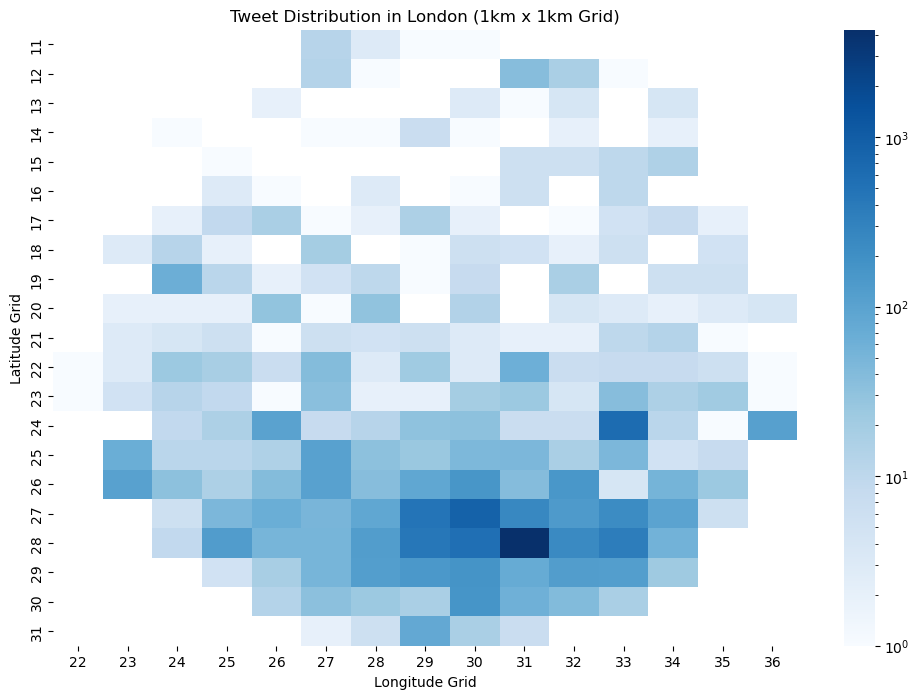

In [11]:
heatmap_data = grid_counts.pivot(index="grid_y", columns="grid_x", values="tweet_count").fillna(0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="Blues", norm=LogNorm()) 
plt.title("Tweet Distribution in London (1km x 1km Grid)")
plt.xlabel("Longitude Grid")
plt.ylabel("Latitude Grid")
plt.show()

Histogram that presents Tweet Distribution

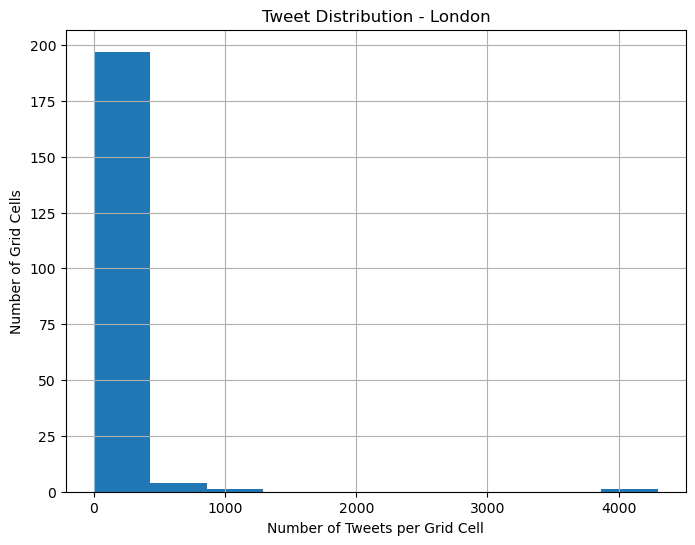

In [12]:
bins = np.arange(0, grid_counts["tweet_count"].max() + 5, 5)
plt.figure(figsize=(8, 6))
plt.hist(grid_counts["tweet_count"])

plt.xlabel("Number of Tweets per Grid Cell")
plt.ylabel("Number of Grid Cells")
plt.title("Tweet Distribution - London")

plt.grid(True)

plt.show()


Newsworthines
=====================


This program evaluates the newsworthiness of tweets based on term frequencies in high-quality, low-quality, and background datasets. The scoring method allows experimentation with different threshold values and the use or removal of stopwords.

1. Adjusting the Threshold Value
The threshold value impacts how terms contribute to newsworthiness scoring.
By default, the program uses a threshold of 2.0, but this can be modified.
The threshold is used in the following functions:
compute_quality_scores()
compute_newsworthiness_score()
evaluate_tweets()
If not explicitly set, the program defaults to 2.0.


2. Using or Removing Stopwords
The program supports the inclusion or removal of stopwords to refine the classification.
Stopwords are loaded into a set and passed as an argument to the evaluate_tweets() function.
To use stopwords, assign a stopword set to the stopwords parameter.
To remove stopwords, do not pass the parameter or pass an empty set {}.


3. Running the Evaluation
The function evaluate_tweets() processes tweets and assigns newsworthiness scores.
It accepts the following parameters:
tweets dataset (e.g., bg_tweets, high_quality, low_quality)
term frequencies (hq_counts, lq_counts, bg_counts)
threshold value (optional, default: 2.0)
stopwords set (optional)
By adjusting these parameters, users can analyze the impact of different thresholds and stopword usage on tweet classification.


Parsing the quality files. They are named "new_" since I converted the old files into original JSON Format. 

In [13]:
path_to_json = 'Data/credModelFiles/'


# with open(os.path.join(path_to_json, 'bgQuality.json'), 'r') as file:
#     lines = file.readlines()

# print(lines)


def parse_quality_files(from_file, to_file):
    data = []
    with open(os.path.join(path_to_json, from_file), 'r') as file:
        for line in file:
          data.append(json.loads(line))
     
    with open(os.path.join(path_to_json, to_file), 'w') as out_file:  
     json.dump(data, out_file, indent=2)

    return data  


bg_tweets = parse_quality_files("bgQuality.txt", "new_bgQuality.json")
low_quality = parse_quality_files("lowQuality.txt", "new_lowQuality.json")
high_quality = parse_quality_files("highQuality.txt", "new_highQuality.json")

print(f"Loaded {len(bg_tweets)} background tweets, {len(high_quality)} high-quality tweets, {len(low_quality)} low-quality tweets.")

   


Loaded 2239 background tweets, 2501 high-quality tweets, 1527 low-quality tweets.


In [14]:
bg_texts = [tweet["text"] for tweet in bg_tweets]
low_texts = [tweet["text"] for tweet in low_quality]
high_texts = [tweet["text"] for tweet in high_quality]

print(f"Example BG Tweet: {bg_texts[0]}")
print(f"Example Low-Quality Tweet: {low_texts[0]}")
print(f"Example High-Quality Tweet: {high_texts[0]}")

Example BG Tweet: ['confidence', 'dont', 'fix', 'lost', 'need', 'negative', 'playing', 'right', 'support', 'well']
Example Low-Quality Tweet: Just posted a photo @ London, United Kingdom https://t.co/YZWvowLCj2
Example High-Quality Tweet: Turisteando (@ Piccadilly Circus in London, Greater London) https://t.co/ear25pmZNc https://t.co/528VOdxIeF


Stopwords

Retriveing stop-words to use in my newsworthiness calculaions

In [15]:
stop_words = set()
with open("Data/stopwordFile.txt", 'r') as file:
    for line in file:
        stop_words.add(line.strip().lower())
print(stop_words)        

{'', 'myself', 'immediatest', 'sanses', 'respectively', 'sines', 'but', 'howbeit', 'neaths', 'withal', 'humph', 'uponed', 'getting', 'abaft', 'mayest', 'nathless', 'gets', 'everywhere', 'shoulding', 'furtherest', 'overalls', 'really', 'amid', 'oftenest', 'ourself', 'w', 'immediately', 'relatively', 'meanwhiles', 'information', 'despites', 'what', 'saidest', 'become', 'as', 'inward', 'nobodies', 'said', 'in', 'necessariest', 'appear', 'fewer', 'syne', 'about', 'tills', 'owning', 'sith', 'notwithstanding', 'fore', 'exes', 'no', 'evened', 'apartest', 'fact', 'variousest', 'hers', 'wheresoever', 'lotting', 'ares', 'chez', 'canting', 'necessarier', 'them', 'around', 'enough', 'our', 'musth', 'into', 'almost', 'downwarder', 'zillion', 'also', 'username', 'hither', 'her', 'done', 'provided', 'upped', 'except', 'you', 'available', 'outed', 'such', 'its', 'afterwards', 'during', 'vis-a-visest', 'oh', 'summat', 'certain', 'relate', 'pleases', 'nigher', 'soer', 'cantest', 'where', 'my', 'appropri

Using spacy for tokenization. I have covered this in my Text as Data module and I believe it is much better approach to a tradional hard coded mode

In [16]:
nlp = spacy.load("en_core_web_sm")

def text_pipeline_spacy(text, stopwords=set()):
    tokens = []
    doc = nlp(text)
    for t in doc:
        if not t.is_punct and not t.is_space:
            lemma = t.lemma_.lower()
            if lemma not in stopwords:
                tokens.append(lemma)
    return tokens


In [17]:
def get_tokens_and_counts(tweets, stopwords=set()):
    all_tokens = []
    for tweet in tweets:
        if isinstance(tweet["text"], list):
            tokens = tweet["text"]
        else:
            tokens = text_pipeline_spacy(tweet["text"], stopwords=stopwords)

        all_tokens.extend(tokens)

    token_counts = Counter(all_tokens)
    total_tokens = sum(token_counts.values())
    return token_counts, total_tokens

bg_counts, bg_total = get_tokens_and_counts(bg_tweets)
high_counts, high_total = get_tokens_and_counts(high_quality)
low_counts, low_total = get_tokens_and_counts(low_quality)


print(f"BG Tokens: {bg_total}, HQ Tokens: {high_total}, LQ Tokens: {low_total}")




BG Tokens: 28392, HQ Tokens: 39071, LQ Tokens: 32508


Likelihood Ratio

In [18]:
def compute_likelihood_ratio(term, model_freq, background_freq):
    tf_model = model_freq.get(term, 0)
    tf_bg = background_freq.get(term, 0)

    F_model = sum(model_freq.values())
    F_bg = sum(background_freq.values())

    P_model = tf_model / F_model if F_model > 0 else 0
    P_bg = tf_bg / F_bg if F_bg > 0 else 0

    if P_bg > 0:
        return P_model / P_bg
    return 0

Computation of Qaulity Scores

In [19]:

# Quality Scores
def compute_quality_scores(term, hq_freq, lq_freq, bg_freq, threshold=2.0):
    R_hq = compute_likelihood_ratio(term, hq_freq, bg_freq)
    R_lq = compute_likelihood_ratio(term, lq_freq, bg_freq)

    S_hq = R_hq if R_hq >= threshold else 0
    S_lq = R_lq if R_lq >= threshold else 0

    return S_hq, S_lq

Cumputation of Newsworthiness Score

In [20]:

def compute_newsworthiness_score(document_terms, hq_freq, lq_freq, bg_freq, threshold=2.0):
    sum_hq_scores = 0
    sum_lq_scores = 0

    for term in document_terms:
        S_hq, S_lq = compute_quality_scores(term, hq_freq, lq_freq, bg_freq, threshold)
        # print(f"Term: {term}, S_hq: {S_hq}, S_lq: {S_lq}")
        sum_hq_scores += S_hq
        sum_lq_scores += S_lq

    score = math.log2((1 + sum_hq_scores) / (1 + sum_lq_scores))
    # print(f"Tweet Terms: {document_terms}")
    # print(f"Sum HQ Scores: {sum_hq_scores}, Sum LQ Scores: {sum_lq_scores}, Newsworthiness Score: {score}")
    return score

Evaluation of Tweets

In [21]:
def evaluate_tweets(tweets, hq_freq, lq_freq, bg_freq, threshold=2.0, stopwords=set()):
    scores = []
    for tweet in tweets:
        if isinstance(tweet['text'], list):
            tokens = tweet['text']
        else:
            tokens = text_pipeline_spacy(tweet['text'], stopwords=stopwords)
        score = compute_newsworthiness_score(tokens, hq_freq, lq_freq, bg_freq, threshold)
        scores.append(score)
    return scores



bg_counts_no_sw, bg_total_no_sw = get_tokens_and_counts(bg_tweets)
hq_counts_no_sw, hq_total_no_sw = get_tokens_and_counts(high_quality)
lq_counts_no_sw, lq_total_no_sw = get_tokens_and_counts(low_quality)

# Get token counts WITH stopwords removed
bg_counts_sw, bg_total_sw = get_tokens_and_counts(bg_tweets, stop_words)
hq_counts_sw, hq_total_sw = get_tokens_and_counts(high_quality, stop_words)
lq_counts_sw, lq_total_sw = get_tokens_and_counts(low_quality, stop_words)

# Evaluate WITHOUT stopwords
bg_scores_no_sw = evaluate_tweets(bg_tweets, hq_counts_no_sw, lq_counts_no_sw, bg_counts_no_sw)
hq_scores_no_sw = evaluate_tweets(high_quality, hq_counts_no_sw, lq_counts_no_sw, bg_counts_no_sw)
lq_scores_no_sw = evaluate_tweets(low_quality, hq_counts_no_sw, lq_counts_no_sw, bg_counts_no_sw)

# Evaluate WITH stopwords removed
bg_scores_sw = evaluate_tweets(bg_tweets, hq_counts_sw, lq_counts_sw, bg_counts_sw, stopwords=stop_words)
hq_scores_sw = evaluate_tweets(high_quality, hq_counts_sw, lq_counts_sw, bg_counts_sw, stopwords=stop_words)
lq_scores_sw = evaluate_tweets(low_quality, hq_counts_sw, lq_counts_sw, bg_counts_sw, stopwords=stop_words)


Displaying the graph showing distribution of newsworthiness score amoun bg, low and high quality tweets

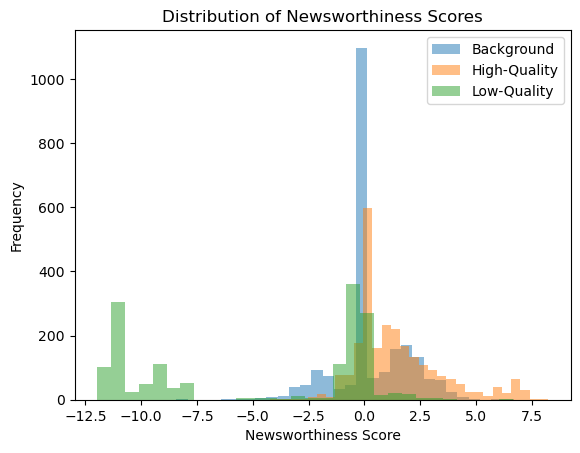

In [22]:
plt.hist(bg_scores_sw, bins=30, alpha=0.5, label='Background')
plt.hist(hq_scores_sw, bins=30, alpha=0.5, label='High-Quality')
plt.hist(lq_scores_sw, bins=30, alpha=0.5, label='Low-Quality')
plt.xlabel('Newsworthiness Score')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Newsworthiness Scores')
plt.show()

Calculating percentages of newsworthy scores in all categories

In [23]:
def percentage_newsworthy(scores):
    num_newsworthy = sum(1 for score in scores if score > 0)
    total = len(scores)
    percentage = (num_newsworthy / total) * 100 if total > 0 else 0
    return percentage, num_newsworthy, total


bg_perc_no_sw, _, _ = percentage_newsworthy(bg_scores_sw)
hq_perc_no_sw, _, _ = percentage_newsworthy(hq_scores_sw)
lq_perc_no_sw, _, _ = percentage_newsworthy(lq_scores_sw)

bg_perc_sw, _, _ = percentage_newsworthy(bg_scores_sw)
hq_perc_sw, _, _ = percentage_newsworthy(hq_scores_sw)
lq_perc_sw, _, _ = percentage_newsworthy(lq_scores_sw)


Priting percentages which are different for different thresholds and using or not using stop words

In [24]:
print("\n==== WITHOUT STOPWORDS ====")
print(f"Background: {bg_perc_no_sw:.2f}% newsworthy")
print(f"High-Quality: {hq_perc_no_sw:.2f}% newsworthy")
print(f"Low-Quality: {lq_perc_no_sw:.2f}% newsworthy")

print("\n==== WITH STOPWORDS REMOVED ====")
print(f"Background: {bg_perc_sw:.2f}% newsworthy")
print(f"High-Quality: {hq_perc_sw:.2f}% newsworthy")
print(f"Low-Quality: {lq_perc_sw:.2f}% newsworthy")


==== WITHOUT STOPWORDS ====
Background: 36.58% newsworthy
High-Quality: 79.49% newsworthy
Low-Quality: 19.78% newsworthy

==== WITH STOPWORDS REMOVED ====
Background: 36.58% newsworthy
High-Quality: 79.49% newsworthy
Low-Quality: 19.78% newsworthy


Displaying a graph that shows percentages in a much visually appealing way.

Background: 819/2239 newsworthy (36.58%)
High-Quality: 1988/2501 newsworthy (79.49%)
Low-Quality: 302/1527 newsworthy (19.78%)


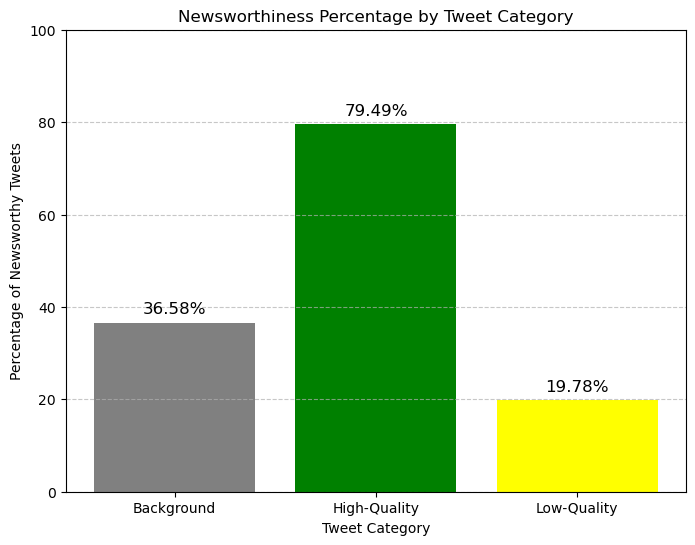

In [25]:
import matplotlib.pyplot as plt

categories = {
    "Background": bg_scores_sw,
    "High-Quality": hq_scores_sw,
    "Low-Quality": lq_scores_sw
}

newsworthy_stats = {}
for category, scores in categories.items():
    percentage, num_newsworthy, total = percentage_newsworthy(scores)
    newsworthy_stats[category] = {
        "percentage": percentage,
        "num_newsworthy": num_newsworthy,
        "total": total
    }

for category, stats in newsworthy_stats.items():
    print(f"{category}: {stats['num_newsworthy']}/{stats['total']} newsworthy ({stats['percentage']:.2f}%)")



categories = list(newsworthy_stats.keys())
total_counts = [stats["total"] for stats in newsworthy_stats.values()]
newsworthy_counts = [stats["num_newsworthy"] for stats in newsworthy_stats.values()]
percentages = [stats["percentage"] for stats in newsworthy_stats.values()]

# Plot
plt.figure(figsize=(8, 6))
plt.bar(categories, percentages, color=['gray', 'green', 'yellow'])
plt.xlabel("Tweet Category")
plt.ylabel("Percentage of Newsworthy Tweets")
plt.title("Newsworthiness Percentage by Tweet Category")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)


for i, v in enumerate(percentages):
    plt.text(i, v + 2, f"{v:.2f}%", ha='center', fontsize=12)

plt.show()    


In [26]:
def score_statistics(scores):
    if not scores:
        return 0, 0, 0  
    min_score = min(scores)
    max_score = max(scores)
    avg_score = sum(scores) / len(scores)
    return min_score, max_score, avg_score

In [27]:
bg_min, bg_max, bg_avg = score_statistics(bg_scores_sw)
hq_min, hq_max, hq_avg = score_statistics(hq_scores_sw)
lq_min, lq_max, lq_avg = score_statistics(lq_scores_sw)

print(f"Background: Min={bg_min:.2f}, Max={bg_max:.2f}, Avg={bg_avg:.2f}")
print(f"High-Quality: Min={hq_min:.2f}, Max={hq_max:.2f}, Avg={hq_avg:.2f}")
print(f"Low-Quality: Min={lq_min:.2f}, Max={lq_max:.2f}, Avg={lq_avg:.2f}")

Background: Min=-8.42, Max=6.68, Avg=0.34
High-Quality: Min=-4.21, Max=8.23, Avg=1.49
Low-Quality: Min=-11.96, Max=6.63, Avg=-4.73


In [28]:
def find_highest_lowest(tweets, scores, category_name):
    tweets_with_scores = list(zip(tweets, scores))
    highest_tweet = max(tweets_with_scores, key=lambda x: x[1])
    lowest_tweet = min(tweets_with_scores, key=lambda x: x[1])

    print(f"\n=== {category_name} ===")
    print(f"Highest {category_name} Tweet Score: {highest_tweet[1]:.2f}")
    print(f"Highest {category_name} Tweet Text: {highest_tweet[0]['text']}")

    print(f"Lowest {category_name} Tweet Score: {lowest_tweet[1]:.2f}")
    print(f"Lowest {category_name} Tweet Text: {lowest_tweet[0]['text']}\n")


find_highest_lowest(high_quality, hq_scores_sw, "High-Quality")
find_highest_lowest(low_quality, lq_scores_sw, "Low-Quality")
find_highest_lowest(bg_tweets, bg_scores_sw, "Background")



=== High-Quality ===
Highest High-Quality Tweet Score: 8.23
Highest High-Quality Tweet Text: Drinks, drinks, drinks
#HappyFriday #stpatricksday @ Mayfair https://t.co/3hbxdsRmoY
Lowest High-Quality Tweet Score: -4.21
Lowest High-Quality Tweet Text: @muteesocrates Exactly. Technically speaking the so called AI is just a classified group of if statements


=== Low-Quality ===
Highest Low-Quality Tweet Score: 6.63
Highest Low-Quality Tweet Text: Drinking a Millions of Peaches by @HackneyBrewery at @tapwaterloo — https://t.co/aii9cyQhya
Lowest Low-Quality Tweet Score: -11.96
Lowest Low-Quality Tweet Text: However, if Al Saud refused the command of Allaah's caliph Al-Mahdi Nasser Mohammed Al-Yamani like the people of Yemen had done before
Imam Nasser Mohammed Al-Yamani.
06-Sha'ban-1443AH
09-March-2022 AD
08:41 AM
https://t.co/JZq1SwuY0U
37
#AlMahdiCaliphOfAllah
 
1|R1ob7


=== Background ===
Highest Background Tweet Score: 6.68
Highest Background Tweet Text: ['2023', '25th', 'book', 'canap

Below I am filtering my data using my newsworthiness algorithm and presenet statistics, as well as before/after results

In [29]:
threshold = 2.0
all_df["newsworthiness_score"] = all_df["text"].apply(lambda x: compute_newsworthiness_score(text_pipeline_spacy(x), high_counts, low_counts, bg_counts, threshold))


In [30]:
filtered_df = all_df[all_df["newsworthiness_score"] > threshold].copy()
filtered_df["grid_x"] = ((filtered_df["longitude"] - london_boundary_box[0]) / long_step).astype(int)
filtered_df["grid_y"] = ((filtered_df["latitude"] - london_boundary_box[1]) / lat_step).astype(int)

filtered_grid_counts = filtered_df.groupby(["grid_x", "grid_y"]).size().reset_index(name="tweet_count")
filtered_df["grid_x"] = ((filtered_df["longitude"] - london_boundary_box[0]) / long_step).astype(int)
filtered_df["grid_y"] = ((filtered_df["latitude"] - london_boundary_box[1]) / lat_step).astype(int)

filtered_grid_counts = filtered_df.groupby(["grid_x", "grid_y"]).size().reset_index(name="tweet_count")

print(f"Total tweets before: {len(all_df)}, after filtering: {len(filtered_df)}")
print(f"Total active grid cells before: {len(grid_counts)}, after filtering: {len(filtered_grid_counts)}")

Total tweets before: 13192, after filtering: 2071
Total active grid cells before: 203, after filtering: 143


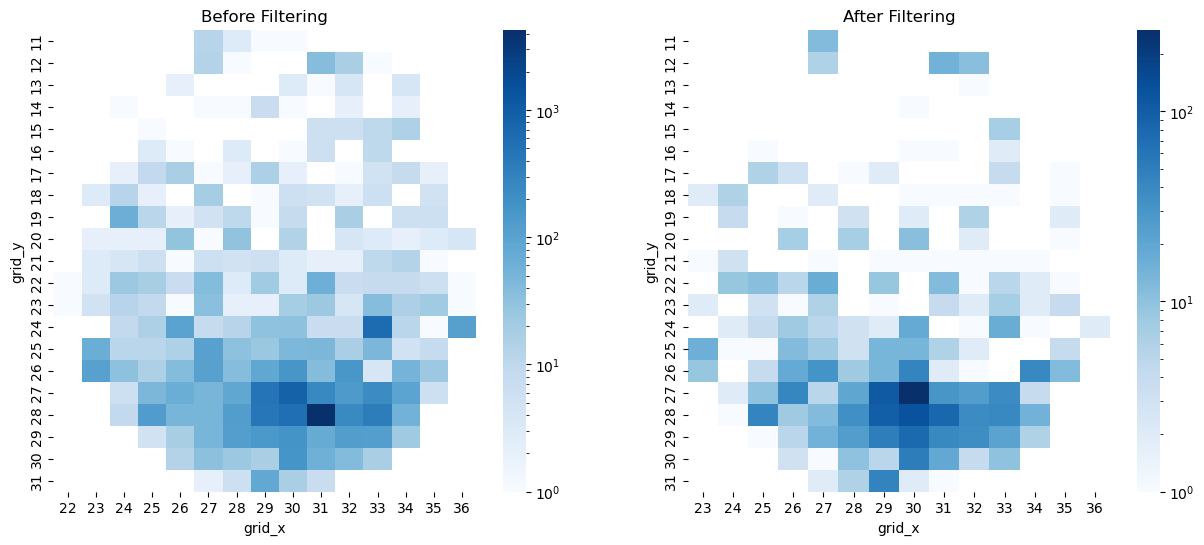

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Before filtering
sns.heatmap(grid_counts.pivot("grid_y", "grid_x", "tweet_count"), norm=LogNorm(),cmap="Blues", ax=axes[0])
axes[0].set_title("Before Filtering")

# After filtering
sns.heatmap(filtered_grid_counts.pivot("grid_y", "grid_x", "tweet_count"),norm=LogNorm(), cmap="Blues", ax=axes[1])
axes[1].set_title("After Filtering")

plt.show()

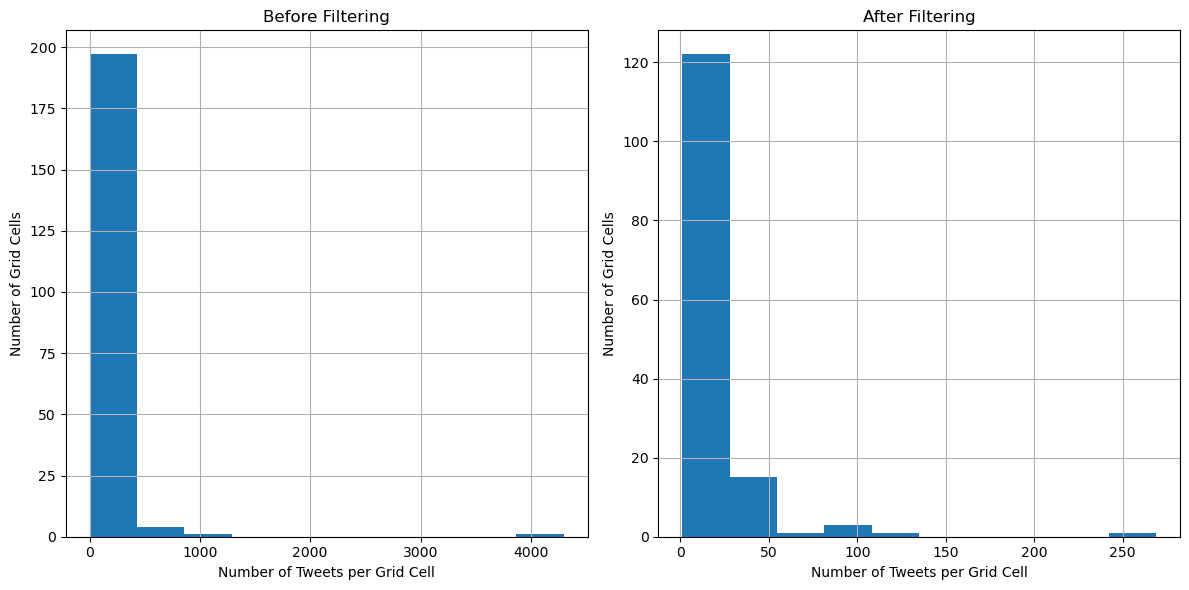

In [32]:

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(grid_counts["tweet_count"])
axes[0].set_xlabel("Number of Tweets per Grid Cell")
axes[0].set_ylabel("Number of Grid Cells")
axes[0].set_title("Before Filtering")
axes[0].grid(True)

axes[1].hist(filtered_grid_counts["tweet_count"])
axes[1].set_xlabel("Number of Tweets per Grid Cell")
axes[1].set_ylabel("Number of Grid Cells")
axes[1].set_title("After Filtering")
axes[1].grid(True)

plt.tight_layout()
plt.show()



In [33]:
total_filtered_tweets = len(filtered_df)

total_filtered_cells = num_columns * num_rows

max_filtered_tweets = filtered_grid_counts["tweet_count"].max()
min_filtered_tweets = filtered_grid_counts["tweet_count"].min()
mean_filtered_tweets = filtered_grid_counts["tweet_count"].mean()
median_filtered_tweets = filtered_grid_counts["tweet_count"].median()
std_dev_filtered_tweets = filtered_grid_counts["tweet_count"].std()

top_5_filtered_cells = filtered_grid_counts.sort_values("tweet_count", ascending=False).head(5)

print(f"Total tweets processed after filtering: {total_filtered_tweets}")
print(f"Total grid cells created after filtering: {total_filtered_cells}")
print(f"Max tweets in a single cell after filtering: {max_filtered_tweets}")
print(f"Min tweets in a single cell after filtering: {min_filtered_tweets}")
print(f"Mean tweets per active grid after filtering: {mean_filtered_tweets:.2f}")
print(f"Median tweets per active grid after filtering: {median_filtered_tweets}")
print(f"Standard Deviation of tweets per grid after filtering: {std_dev_filtered_tweets:.2f}")
print("Top 5 Busiest Grid Cells After Filtering:")
print(top_5_filtered_cells)

Total tweets processed after filtering: 2071
Total grid cells created after filtering: 2832
Max tweets in a single cell after filtering: 269
Min tweets in a single cell after filtering: 1
Mean tweets per active grid after filtering: 14.48
Median tweets per active grid after filtering: 5.0
Standard Deviation of tweets per grid after filtering: 29.82
Top 5 Busiest Grid Cells After Filtering:
    grid_x  grid_y  tweet_count
81      30      27          269
82      30      28          130
67      29      27          108
68      29      28           98
95      31      28           82
